# GO terms DEGs
In our transcriptomics visualization notebook, we exported some groups of genes that we want to get GO term enrichments for; here is where we'll do that, using the PANTHER API.

In [62]:
from os import listdir
from os.path import splitext, isfile
import requests
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import numpy as np
from upsetplot import from_contents, plot, UpSet
import warnings
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import warnings
from matplotlib.colors import LogNorm

## Read in the data

In [2]:
datapath = '../data/Araport11_outputs_ALL/deseq2_output/'
data = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    if f.split('_')[1] == 'o2':
        data[name] = pd.read_csv(datapath+f).gene_id.tolist()

Define the semantic mapping for later use:

In [8]:
conditions_semantic = {
    '1h_o2_2_21': '2% oxygen at 1 hour',
    '1h_o2_40_21': '40% oxygen at 1 hour',
    '7h_o2_2_21': '2% oxygen at 7 hours',
    '7h_o2_40_21': '40% oxygen at 7 hours'
}
reverse_semantic = {v: k for k, v in conditions_semantic.items()}

## Define API call function
We're going to use the [PANTHER API](https://pantherdb.org/services/openAPISpec.jsp) to do our GO term enrichment.

In [4]:
def getPANTHER(query, checkPageInfo=True):
    """
    Get GO terms from a mmultiple-page search result.
    """
    # Check number of pages
    r = requests.get(query, headers={ "Accept" : "application/json"})
    if not r.ok:
      r.raise_for_status()
      sys.exit()
    responseBody = r.json()
    overall_jsons = responseBody['results']

    return overall_jsons

## Formulate queries and make API call

In [5]:
enrichments = defaultdict(dict)
for comp, genes in tqdm(data.items()):
    gene_list = ','.join(genes)
    enriches = {}
    for go_name, go_set in {
                            'GO%3A0008150': 'biological_process',
                            'GO%3A0003674': 'molecular_function',
                            'GO%3A0005575': 'cellular_component'
                            }.items():
        enrich_query = f'https://pantherdb.org/services/oai/pantherdb/enrich/overrep?geneInputList={gene_list}&organism=3702&annotDataSet={go_name}&enrichmentTestType=FISHER&correction=FDR&mappedInfo=COMP_LIST'
        result_json = getPANTHER(enrich_query)
        enriches[go_set] = result_json
    enrichments[comp] = enriches

100%|██████████| 4/4 [00:18<00:00,  4.65s/it]


## Process results
Note that the chimeric transcripts and novel genes are not able to be mapped to GO terms, and so are excluded. In the `unmapped_id` lists there are also some normal-looking TAIR ID's; I assume that there is some base error in mapping genes to GO terms wtih this tool.

In [28]:
def processGOenrichments(enrichments, data, conditions_semantic):
    """
    Make a summary dataframe with GO terms from each aspect that are enriched
    in each group, and print a summary of the numbers.
    """
    processed_go = {
        'group': [],
        'aspect': [],
        'term': [],
        'GOid': [],
        'p_value_fdr': [],
        'associated_gene_IDs': [],
        'plus_minus': []
    }
    for group, res in enrichments.items():
        for aspect in res:
            for termDict in res[aspect]['result']:
                if termDict['fdr'] < 0.05:
                    processed_go['group'].append(group)
                    processed_go['aspect'].append(aspect)
                    processed_go['term'].append(termDict['term']['label'])
                    try:
                        processed_go['GOid'].append(termDict['term']['id'])
                    except KeyError:
                        processed_go['GOid'].append(np.nan)
                    processed_go['p_value_fdr'].append(termDict['fdr'])
                    try:
                        processed_go['associated_gene_IDs'].append(termDict['input_list']['mapped_ids'])
                        processed_go['plus_minus'].append('+')
                    except KeyError:
                        processed_go['associated_gene_IDs'].append(np.nan)
                        processed_go['plus_minus'].append('-')
                        

    go_results = pd.DataFrame(processed_go)
    go_results = go_results.set_index(['group', 'aspect']).sort_index()

    for group in data:
        print(f'\nFor comparison group {conditions_semantic[group]}, there are...')
        for aspect in ['biological_process', 'molecular_function', 'cellular_component']:
            try:
                print(f'{len(go_results.loc[(group, aspect)])} {aspect} GO terms')
            except KeyError:
                print(f'0 {aspect} GO terms')
        print(f'... enriched, for a total of {len(data[group])} genes in the comparison.\n')

    return go_results

In [27]:
go_enrichment_data = processGOenrichments(enrichments, data, conditions_semantic)
go_enrichment_data.head()


For comparison group 40% oxygen at 1 hour, there are...
14 biological_process GO terms
1 molecular_function GO terms
0 cellular_component GO terms
... enriched, for a total of 70 genes in the comparison.


For comparison group 2% oxygen at 1 hour, there are...
19 biological_process GO terms
5 molecular_function GO terms
3 cellular_component GO terms
... enriched, for a total of 40 genes in the comparison.


For comparison group 40% oxygen at 7 hours, there are...
13 biological_process GO terms
1 molecular_function GO terms
0 cellular_component GO terms
... enriched, for a total of 40 genes in the comparison.


For comparison group 2% oxygen at 7 hours, there are...
94 biological_process GO terms
6 molecular_function GO terms
21 cellular_component GO terms
... enriched, for a total of 405 genes in the comparison.



term  \
group      aspect                                                             
1h_o2_2_21 biological_process                  xyloglucan metabolic process   
           biological_process                  cellular response to hypoxia   
           biological_process  cellular response to decreased oxygen levels   
           biological_process            cellular response to oxygen levels   
           biological_process                           response to hypoxia   

                                     GOid  p_value_fdr  \
group      aspect                                        
1h_o2_2_21 biological_process  GO:0010411     0.000089   
           biological_process  GO:0071456     0.000060   
           biological_process  GO:0036294     0.000042   
           biological_process  GO:0071453     0.000033   
           biological_process  GO:0001666     0.000054   

                                                             associated_gene_IDs  \
group      aspect                                                                  
1h_o2_2_21 biological_process  AT5G57560,AT4G30280,AT1G65310,AT4G25810,AT1G10550   
           biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   
           biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   
           biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   
           biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   

                              plus_minus  
group      aspect                         
1h_o2_2_21 biological_process          +  
           biological_process          +  
           biological_process          +  
           biological_process          +  
           biological_process          +

Save the dataframe output, but replace outer index with semantic values first:

In [10]:
multi = go_enrichment_data.index.tolist()
multi_replace = pd.MultiIndex.from_tuples([(conditions_semantic[i], j) for i, j in multi])
go_enrichment_data.index = multi_replace
go_enrichment_data.head()

term  \
2% oxygen at 1 hour biological_process                  xyloglucan metabolic process   
                    biological_process                  cellular response to hypoxia   
                    biological_process  cellular response to decreased oxygen levels   
                    biological_process            cellular response to oxygen levels   
                    biological_process                           response to hypoxia   

                                              GOid  p_value_fdr  \
2% oxygen at 1 hour biological_process  GO:0010411     0.000089   
                    biological_process  GO:0071456     0.000060   
                    biological_process  GO:0036294     0.000042   
                    biological_process  GO:0071453     0.000033   
                    biological_process  GO:0001666     0.000054   

                                                                      associated_gene_IDs  \
2% oxygen at 1 hour biological_process  AT5G57560,AT4G30280,AT1G65310,AT4G25810,AT1G10550   
                    biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   
                    biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   
                    biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   
                    biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   

                                       plus_minus  
2% oxygen at 1 hour biological_process          +  
                    biological_process          +  
                    biological_process          +  
                    biological_process          +  
                    biological_process          +

In [11]:
go_enrichment_data.to_csv('../data/Araport11_outputs_ALL/panther_API_go_enrichments/PANTHER_GO_enrichments_oxygen_comp_WITH_GENEIDS_02May2025.csv', index=True)

In [39]:
## START HERE if you don't want to re-run enrichment
go_enrichment_data = pd.read_csv('../data/Araport11_outputs_ALL/panther_API_go_enrichments/PANTHER_GO_enrichments_oxygen_comp_WITH_GENEIDS_02May2025.csv').rename(columns={'Unnamed: 0': 0, 'Unnamed: 1': 1}).set_index([0, 1])
go_enrichment_data.head()

term  \
0                   1                                                                  
2% oxygen at 1 hour biological_process                  xyloglucan metabolic process   
                    biological_process                  cellular response to hypoxia   
                    biological_process  cellular response to decreased oxygen levels   
                    biological_process            cellular response to oxygen levels   
                    biological_process                           response to hypoxia   

                                              GOid  p_value_fdr  \
0                   1                                             
2% oxygen at 1 hour biological_process  GO:0010411     0.000089   
                    biological_process  GO:0071456     0.000060   
                    biological_process  GO:0036294     0.000042   
                    biological_process  GO:0071453     0.000033   
                    biological_process  GO:0001666     0.000054   

                                                                      associated_gene_IDs  \
0                   1                                                                       
2% oxygen at 1 hour biological_process  AT5G57560,AT4G30280,AT1G65310,AT4G25810,AT1G10550   
                    biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   
                    biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   
                    biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   
                    biological_process  AT5G57560,AT1G35140,AT4G30280,AT5G20150,AT5G20...   

                                       plus_minus  
0                   1                              
2% oxygen at 1 hour biological_process          +  
                    biological_process          +  
                    biological_process          +  
                    biological_process          +  
                    biological_process          +

Plot the number of genes in each enriched term, for the top 15 GO terms in each category. First, we need to wrangle the data farther:

In [20]:
total_in_cat = {
    conditions_semantic[k]: len(df) for k, df in data.items()
}

In [41]:
go_enrichment_data.loc[:, 'count'] = go_enrichment_data['associated_gene_IDs'].str.split(',').apply(len)

In [42]:
go_enrichment_data.loc[:, 'category_total'] = go_enrichment_data.index.get_level_values(0).map(total_in_cat)
go_enrichment_data.loc[:, 'gene_ratio'] = go_enrichment_data['count']/go_enrichment_data['category_total']

In [48]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    # Plotting code adapted from https://github.com/gingraslab/go_terms_dot_plot/blob/main/src/go_terms_dot_plot.py
    # -------------------------------------------------------------------------------------------------------------
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

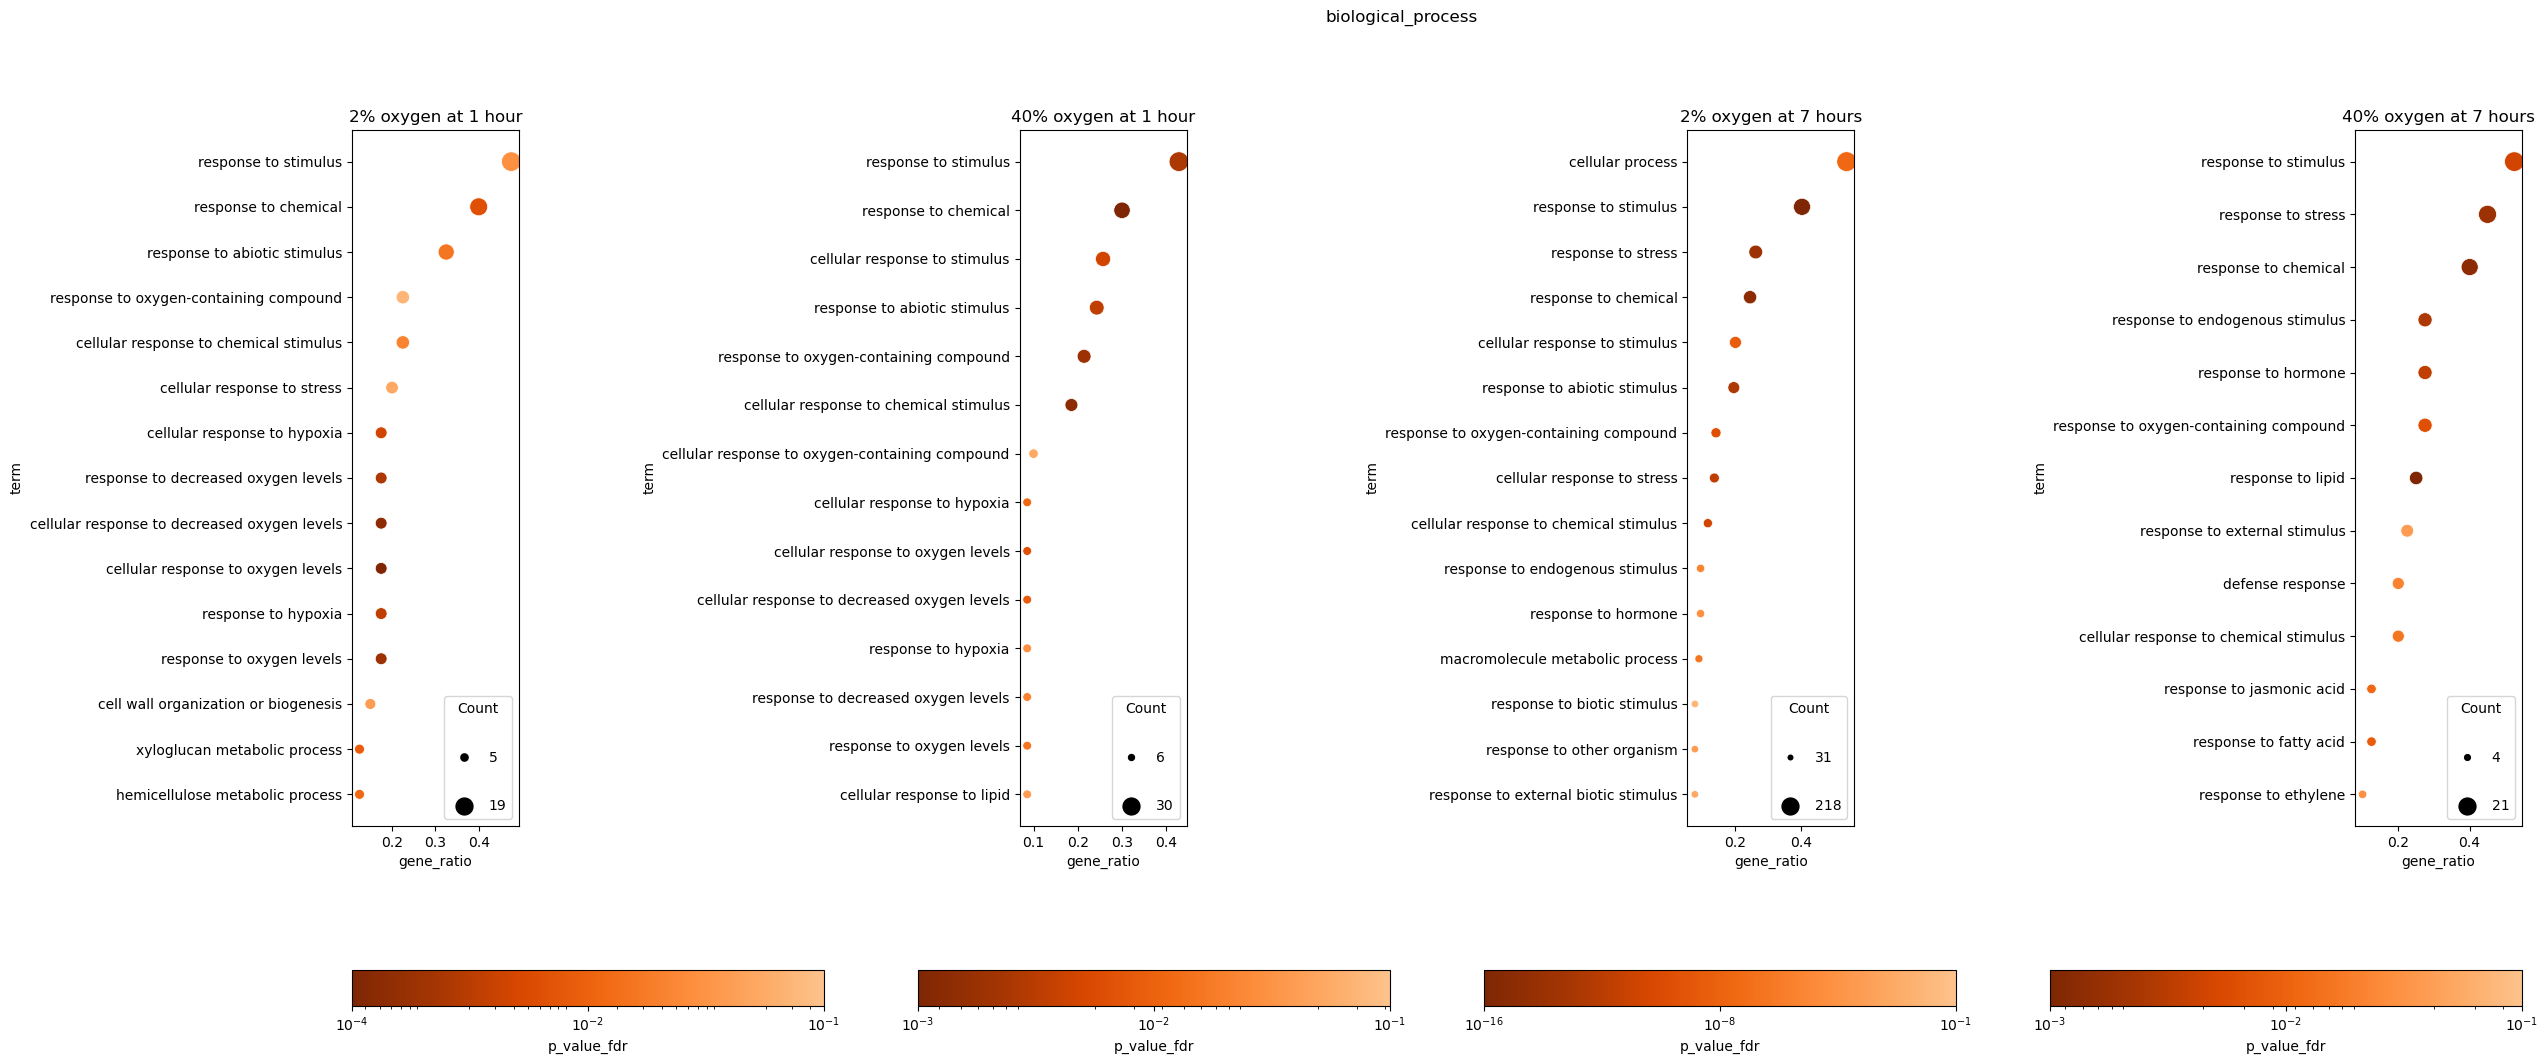

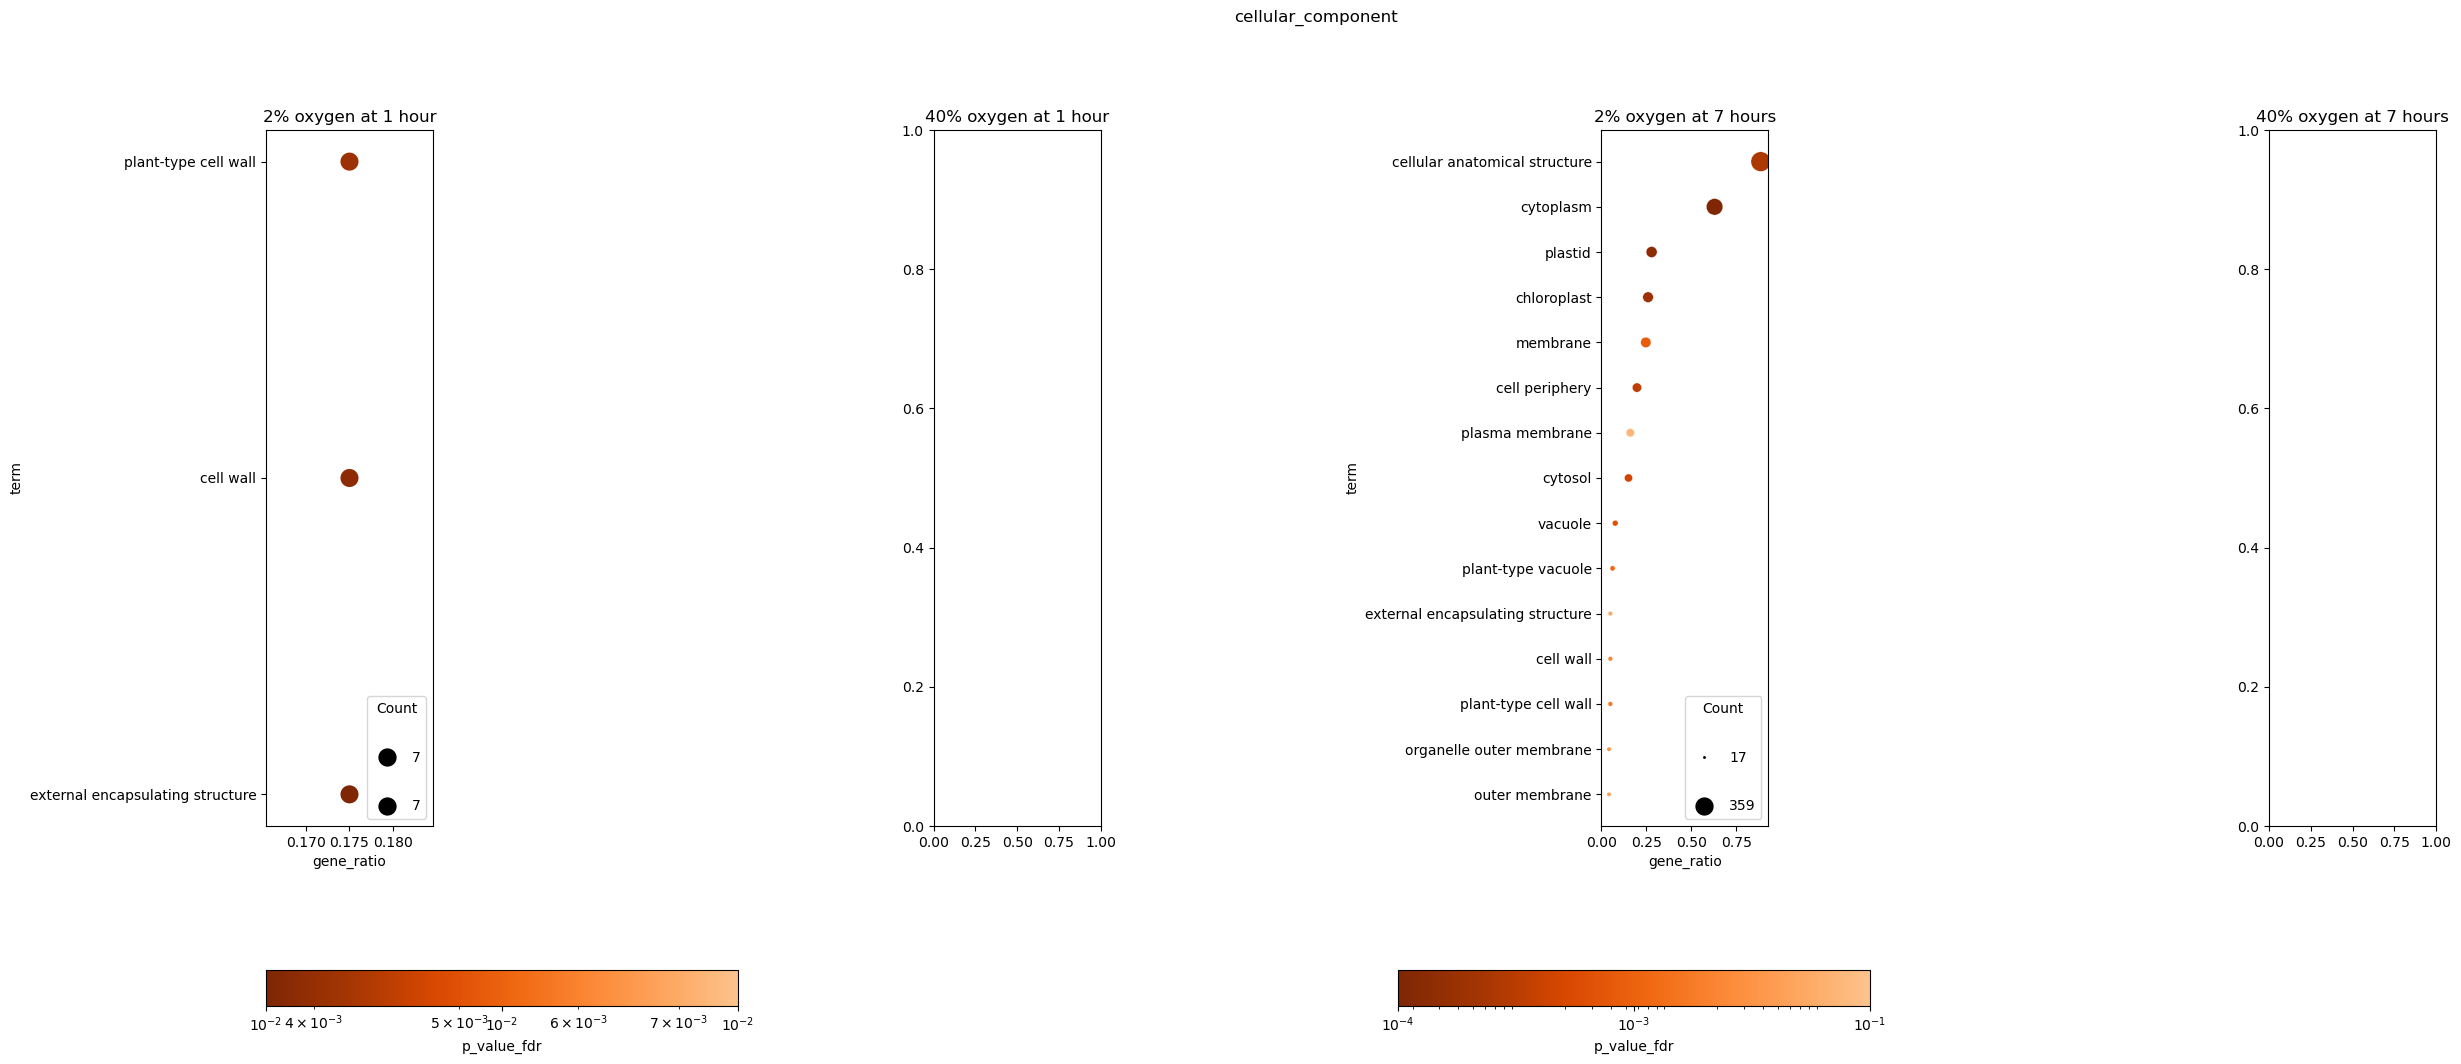

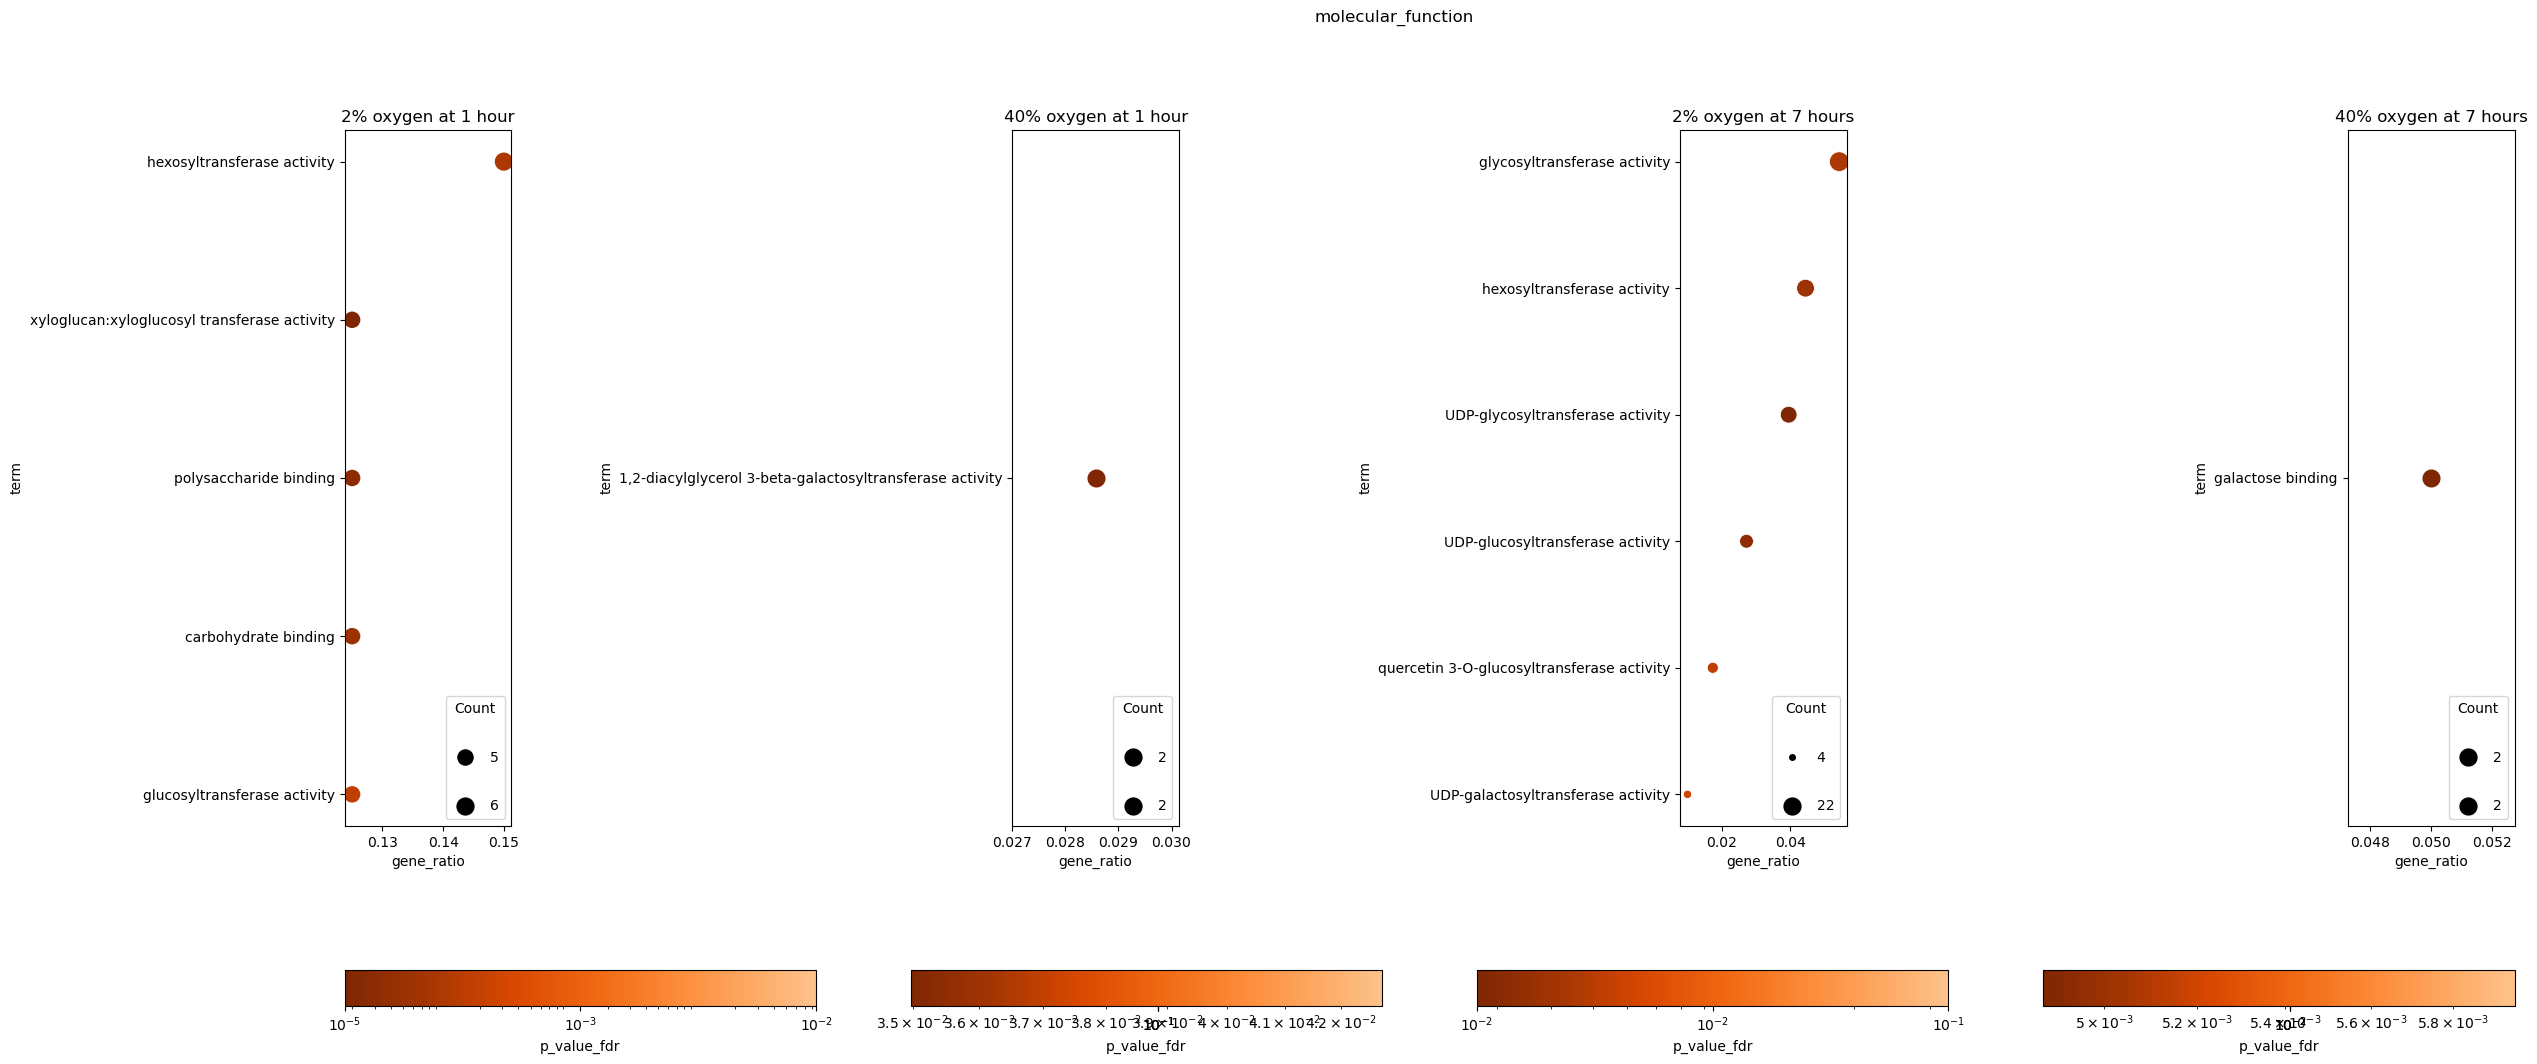

In [71]:
warnings.filterwarnings('ignore')
for aspect in ['biological_process', 'cellular_component', 'molecular_function']:

    fig, axs = plt.subplots(1, len(data), figsize=(len(data)*7, 12))

    for ax, comparison in zip(axs.flat, go_enrichment_data.index.get_level_values(0).unique()):

        # Get data to plot
        try:
            sub_to_plot = go_enrichment_data.loc[(comparison, aspect), :].sort_values(by='gene_ratio', ascending=False).iloc[:15, :]
        except KeyError:
            ax.set_title(comparison)
            continue

        # Plotting code adapted from https://github.com/gingraslab/go_terms_dot_plot/blob/main/src/go_terms_dot_plot.py
        # -------------------------------------------------------------------------------------------------------------
        # Create colormap
        cmap = cm.get_cmap('Oranges_r')
        cmap = truncate_colormap(cmap, 0.0, 0.7)

        # Map p-values to colormap
        color_dict = {p: cmap(i/15) for i, p in enumerate(sorted(sub_to_plot['p_value_fdr'].unique()))}

        # Calculate scaled sizes for the plot
        max_size = sub_to_plot['count'].max()
        sub_to_plot['scaled_count'] = (sub_to_plot['count'] / max_size) * 200  # Scale sizes proportionally
        
        # Create a sizes dictionary that maps every unique scaled size to a specific plot size
        unique_scaled_sizes = sub_to_plot['scaled_count'].unique()
        sizes_dict = {size: size for size in unique_scaled_sizes}
    
        # Create the scatter plot using the sizes dictionary
        sns.scatterplot(x='gene_ratio', y='term', size='scaled_count', hue='p_value_fdr',
                        data=sub_to_plot, palette=color_dict, sizes=sizes_dict, ax=ax)
    
        # Calculate the smallest and largest sizes for the legend
        smallest_size_scaled = sub_to_plot['scaled_count'].min()
        largest_size_scaled = sub_to_plot['scaled_count'].max()
    
        # Create size legend with exact plot sizes
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                      markersize=np.sqrt(size),  # Convert area size to diameter
                                      markerfacecolor='black', label=f'{int(sub_to_plot[sub_to_plot["scaled_count"] == size]["count"].iloc[0])}') 
                          for size in [smallest_size_scaled, largest_size_scaled]]
        lgd = ax.legend(handles=legend_elements, title='Count', loc='lower right', labelspacing=2.5)
    
        # Get the minimum and maximum adjusted p-values
        min_p = sub_to_plot['p_value_fdr'].min()
        max_p = sub_to_plot['p_value_fdr'].max()
    
        # Create a logarithmic normalization object based on these values
        norm = LogNorm(vmin=min_p, vmax=max_p)
    
        # Calculate the middle value for the p-value range on a log scale
        middle_p = np.sqrt(min_p * max_p)
    
        # Create colorbar with three ticks: min, middle, and max p-values
        fig.subplots_adjust(bottom=0.3)
        
        cax = fig.add_axes([ax.get_position().x0, ax.get_position().y0 - 0.15, ax.get_position().width, 0.03])
        cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal', 
                        ticks=[min_p, middle_p, max_p])
        cb.set_label('p_value_fdr')
    
        # Set the tick labels, using scientific notation
        cb.ax.set_xticklabels([f'$10^{{{int(np.log10(t))}}}$' for t in [min_p, middle_p, max_p]])

        ax.set_title(comparison)

    fig.subplots_adjust(wspace=3)
    fig.suptitle(aspect)